In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!sudo apt-get update
!sudo apt-get install ffmpeg

In [1]:
import pandas as pd

csv_file_path = '/kaggle/input/carcrash-binaryannotations/annotations.csv'
annotations = pd.read_csv(csv_file_path)

class_counts = annotations['label'].value_counts()
print(class_counts)

label
1    1415
0      85
Name: count, dtype: int64


In [ ]:
import os
import pandas as pd

video_dir = '/kaggle/input/crash-1500/Crash-1500'
frames_dir = '/kaggle/working/frames' 

for idx, row in annotations.iterrows():
    video_number = row['Video Number']
    video_path = os.path.join(video_dir, f'{video_number:06}.mp4')
    output_dir = os.path.join(frames_dir, f'{video_number:06}')
    os.makedirs(output_dir, exist_ok=True)

    ffmpeg_command = f'ffmpeg -ss 00:00:01 -i "{video_path}" -vf fps=5 "{output_dir}/frame%04d.png"'
#     print(f"Running FFmpeg command: {ffmpeg_command}")
    os.system(ffmpeg_command)
    
    extracted_frames = os.listdir(output_dir)
    print(f"Extracted {len(extracted_frames)} frames for video {video_number}")

In [2]:
import os
frames_dir = '/kaggle/working/frames'
video_dirs = next(os.walk(frames_dir))[1]
num_videos = len(video_dirs)

print(f"Number of videos with extracted frames: {num_videos}")

Number of videos with extracted frames: 1500


In [3]:
import os
import glob
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from PIL import Image

class VideoDataset(Dataset):
    def __init__(self, annotations_df, root_dir, minority_transform=None, majority_transform=None, num_frames=20):
        self.annotations = annotations_df
        self.root_dir = root_dir
        self.minority_transform = minority_transform
        self.majority_transform = majority_transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        video_number = self.annotations.iloc[idx]['Video Number']
        label = int(self.annotations.iloc[idx]['label'])  # Binary label (0 or 1)
        frame_dir = os.path.join(self.root_dir, f'{video_number:06}')
        
        frame_files = sorted(glob.glob(os.path.join(frame_dir, '*.png')))[:self.num_frames]
        frames = []

        # Select appropriate transform
        transform = self.minority_transform if label == 0 else self.majority_transform

        for frame_path in frame_files:
            frame = read_image(frame_path)  # C x H x W
            frame = transforms.ToPILImage()(frame)  # Convert to PIL for transforms
            if transform:
                frame = transform(frame)
            frames.append(frame)

        if not frames: 
            raise ValueError(f"No frames found for video {video_number} in directory {frame_dir}")

        while len(frames) < self.num_frames:
            frames.append(frames[-1])

        frames = torch.stack(frames)  
        label = torch.tensor(label, dtype=torch.float)  
        return frames, label

minority_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
])

majority_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.ToTensor(),
])

dataset = VideoDataset(
    annotations_df=annotations,
    root_dir='/kaggle/working/frames',
    minority_transform=minority_transform,
    majority_transform=majority_transform
)

In [4]:
import torch
from transformers import TimesformerModel, TimesformerConfig
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

2025-05-10 12:10:10.337777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746879010.571605      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746879010.639941      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
class VideoClassifier(nn.Module):
    def __init__(self, num_classes, num_frames, hidden_size=512, num_layers=1, bidirectional=True, num_heads=4):
        super().__init__()
        self.config = TimesformerConfig(
            num_frames=num_frames,
            num_classes=num_classes  
        )
        self.timesformer = TimesformerModel(self.config)
        self.lstm = nn.LSTM(
            input_size=self.config.hidden_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            bidirectional=bidirectional, 
            batch_first=True,
        )
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size

        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=lstm_output_size, 
            num_heads=num_heads, 
            batch_first=True
        )
        self.classifier = nn.Linear(lstm_output_size, 1)  
    def forward(self, x):
        transformer_output = self.timesformer(x).last_hidden_state  
        lstm_output, _ = self.lstm(transformer_output)          
        
        attn_output, _ = self.multihead_attention(lstm_output, lstm_output, lstm_output)         
        context_vector = torch.sum(attn_output, dim=1)       
        logits = self.classifier(context_vector) 
        return logits

        
model = VideoClassifier(num_classes=1, num_frames=20)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VideoClassifier(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense): Linear(in_featu

In [6]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler, SubsetRandomSampler
from collections import Counter

np.random.seed(21)
all_labels = annotations['label'].values 
dataset_size = len(dataset)

indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split = int(np.floor(0.7 * dataset_size))
val_split = int(np.floor(0.2 * dataset_size))
test_split = dataset_size - train_split - val_split

train_indices = indices[:train_split]
val_indices = indices[train_split:train_split + val_split]
test_indices = indices[train_split + val_split:]

print(f"Total dataset size: {dataset_size}")
print(f"Training set size: {len(train_indices)}")
print(f"Validation set size: {len(val_indices)}")
print(f"Test set size: {len(test_indices)}")

train_labels = all_labels[train_indices]
class_counts = Counter(train_labels)

total_samples = len(train_labels)

class_weights = {label: total_samples / count for label, count in class_counts.items()}
print(f"Unnormalized class weights: {class_weights}")

sample_weights = [class_weights[label] for label in train_labels]

train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_indices), replacement=True)

val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=2, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=2, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=2, sampler=test_sampler)

print("Total effective samples in training set:", len(train_loader) * train_loader.batch_size)

Total dataset size: 1500
Training set size: 1050
Validation set size: 300
Test set size: 150
Unnormalized class weights: {1: 1.0584677419354838, 0: 18.103448275862068}
Total effective samples in training set: 1050


In [8]:
class PenalizedFocalLoss(nn.Module):
    def __init__(self, alpha, gamma, penalty_factor):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.penalty = penalty_factor

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        false_pos_mask = (targets == 0) & (torch.sigmoid(inputs) > 0.5)
        focal_loss[false_pos_mask] *= self.penalty

        return focal_loss.mean()

[1] train_loss: 744.337, val_loss: 0.024, val_acc: 94.667
Best model saved at epoch 1 with val_acc: 94.667
[2] train_loss: 0.042, val_loss: 0.022, val_acc: 94.667
Best model saved at epoch 2 with val_acc: 94.667
[3] train_loss: 0.027, val_loss: 0.024, val_acc: 94.667
Best model saved at epoch 3 with val_acc: 94.667
[4] train_loss: 0.024, val_loss: 0.024, val_acc: 94.667
Best model saved at epoch 4 with val_acc: 94.667
[5] train_loss: 7403.220, val_loss: 91.900, val_acc: 94.667
Best model saved at epoch 5 with val_acc: 94.667
Early stopping at epoch 5


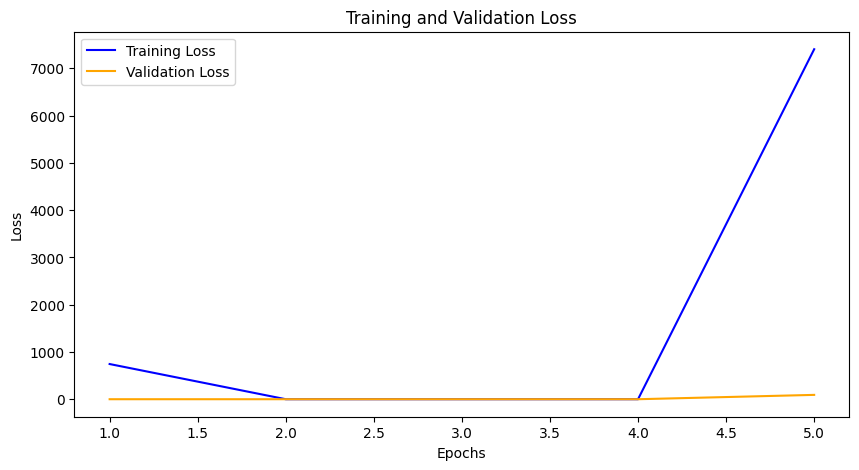

In [9]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = PenalizedFocalLoss(alpha=0.95, gamma=5, penalty_factor=5.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5
save_path = '/kaggle/working/best_model.pth'  

patience = 3  
min_delta = 0.001  
early_stop_counter = 0

best_val_loss = float('inf')  
best_val_acc = 0.0  

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total

    print(f'[{epoch + 1}] train_loss: {avg_train_loss:.3f}, val_loss: {avg_val_loss:.3f}, val_acc: {val_acc:.3f}')

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved at epoch {epoch + 1} with val_acc: {val_acc:.3f}")

    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


/tmp/ipykernel_31/1924659417.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


Test Accuracy: 0.9267

Classification Report:
              precision    recall  f1-score   support

Non-Accident       0.00      0.00      0.00        11
    Accident       0.93      1.00      0.96       139

    accuracy                           0.93       150
   macro avg       0.46      0.50      0.48       150
weighted avg       0.86      0.93      0.89       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


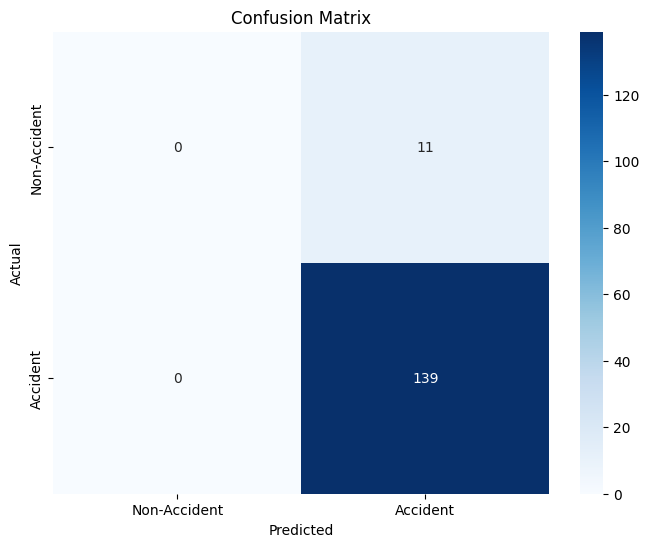

In [10]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model = model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1) 
        
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.3).float()  # Threshold at 0.5
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

test_acc = (all_preds == all_labels).mean()
print(f'Test Accuracy: {test_acc:.4f}')

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non-Accident', 'Accident']))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Accident', 'Accident'], 
            yticklabels=['Non-Accident', 'Accident'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()